In [1]:
import pandas as pd
import numpy as np
import pydicom 
import os
import matplotlib.pyplot as plt

from skimage.measure import label,regionprops
from skimage.segmentation import clear_border

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv('sample_submission.csv')

In [3]:
def load_scans(path):
    slices = [pydicom.dcmread(path + '/' + file) for file in os.listdir(path)]
    slices.sort(key = lambda x : float(x.ImagePositionPatient[2]))
    return slices

In [4]:
def lung_slices_pic(slices):
    slices_3d = []
    for slc in slices:
        tmp_dicom = slc.pixel_array
        img = (tmp_dicom + slc.RescaleIntercept)/ slc.RescaleSlope
        img = img < -400
        img = clear_border(img)
        
        img = label(img)
        
        areas = [r.area for r in regionprops(img)]
        areas.sort()
        if len(areas) > 2:
            for region in regionprops(img):
                if region.area < areas[-2]:
                    for coordinates in region.coords:                
                        img[coordinates[0], coordinates[1]] = 0
        img = img > 0
        
        
        slices_3d.append(img*tmp_dicom)
        
    return np.array(slices_3d)

In [5]:
def best_slice(array):
    tmp_best = array[0]
    pixel_nr = 0
    for i in range(1,array.shape[0]):
        if (array[i]!=0).sum() > pixel_nr:
            tmp_best = array[i]
            pixel_nr = (array[i]!=0).sum()
    return tmp_best

In [6]:
patients = train.Patient.unique()

In [7]:
#example = 'train/' + patients[20]
#example_3d = lung_slices_pic(load_scans(example))

#plt.figure(figsize=(20,20))
#plt.imshow(best_slice(example_3d))

In [8]:
#train_ct = pd.DataFrame(index=patients, columns=['CT'])
#train_ct = train_ct.drop(index = ['ID00011637202177653955184', 'ID00026637202179561894768', 'ID00132637202222178761324'])

In [9]:
train_ct_test = pd.DataFrame(index=patients[100:120], columns=['CT'])

In [10]:
for ind in train_ct_test.index:
    train_ct_test.loc[ind].CT = best_slice( lung_slices_pic(load_scans( 'train/' + ind  )) )

In [11]:
#train_ct_test[train_ct_test.CT.isna()]

In [12]:
train_ct_test.head()

,CT
ID00232637202260377586117,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
ID00233637202260580149633,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
ID00234637202261078001846,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
ID00235637202261451839085,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
ID00240637202264138860065,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [13]:
train_ct_test.to_csv('train_CT_test.csv')
#train_ct_test = pd.read_csv('train_CT_test.csv')

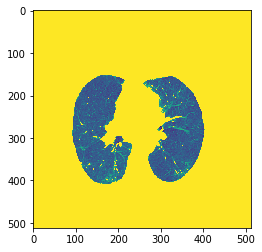

In [14]:
plt.imshow(train_ct_test.CT.iloc[0])

In [55]:
for ind in train_ct_test.index:
    np.savetxt('best_lung_slice/' + ind  + '.txt', train_ct_test.loc[ind].CT) 

In [71]:
def load_best_slices(path):
    ind = []
    for file in os.listdir(path):
        if file.split('.')[1] == 'txt':
            ind.append(file.split('.')[0])
        
    df = pd.DataFrame(index = ind, columns= ['CT'])
    for ind in df.index:
        df.loc[ind].CT = np.loadtxt(path + ind + '.txt')
    
    return df

In [72]:
df = load_best_slices('best_lung_slice/')

In [73]:
df.head()

,CT
ID00264637202270643353440,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
ID00234637202261078001846,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
ID00241637202264294508775,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
ID00267637202270790561585,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
ID00233637202260580149633,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


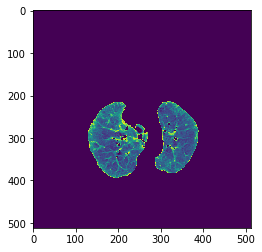

In [74]:
plt.imshow(df.iloc[0].CT)

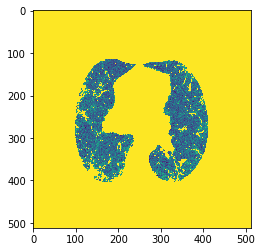

In [81]:
plt.imshow(df.iloc[8].CT)

In [25]:
train_ct_test.iloc[0].CT.shape

(512, 512)

In [65]:
train_ct_test.CT.apply(lambda x: x.max())

ID00232637202260377586117      0
ID00233637202260580149633    623
ID00234637202261078001846      0
ID00235637202261451839085    623
ID00240637202264138860065      0
ID00241637202264294508775      0
ID00242637202264759739921      0
ID00248637202266698862378      0
ID00249637202266730854017      0
ID00251637202267455595113    623
ID00255637202267923028520    623
ID00264637202270643353440    599
ID00267637202270790561585      0
ID00273637202271319294586    623
ID00275637202271440119890      0
ID00276637202271694539978    623
ID00279637202272164826258    623
ID00283637202278714365037    623
ID00285637202278913507108    623
ID00288637202279148973731      0
Name: CT, dtype: int64